# Sarcasm Detection

### Set up

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 27.3 MB/s eta 0:00:00


In [2]:
!pip install -q tf-models-official==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Get and Load Data

In [4]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.4
    Uninstalling gdown-4.6.4:
      Successfully uninstalled gdown-4.6.4


In [5]:
!gdown --id 1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz
To: /content/SarcasmDetect.json
100% 6.06M/6.06M [00:00<00:00, 43.8MB/s]


In [6]:
import pandas as pd

df = pd.read_json('./SarcasmDetect.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


In [8]:
df[["is_sarcastic","headline"]].head(10)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clock of hair loss
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality"
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting to work
4,1,mother comes pretty close to using word 'streaming' correctly
5,0,my white inheritance
6,0,5 ways to file your taxes with less stress
7,1,richard branson's global-warming donation nearly as much as cost of failed balloon trips
8,1,shadow government getting too large to meet in marriott conference room b
9,0,lots of parents know this scenario


## Remove all records with no headline text

In [9]:
df = df[df['headline'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 894.3+ KB


## Preparing Train, Validation and Test Datasets

Following is the dataset scheme we will use for modeling to simulate a small labeled dataset problem

- __Train Dataset:__ 70% Headlines
- __Test Dataset:__ 30% Headlines



In [10]:
from sklearn.model_selection import train_test_split

headlines = df['headline'].values
is_fake = df['is_sarcastic'].values


train_h, test_h, train_if, test_if = train_test_split(headlines, is_fake, test_size=0.3, random_state = 42)
train_h.shape, test_h.shape, train_if.shape, test_if.shape

((20033,), (8586,), (20033,), (8586,))

In [11]:
train_h

array(['american express to offer 5 months of paternity and maternity leave',
       'watch: dolphin knocks stand-up paddleboarder off his board',
       'man who enjoys thing informed he is wrong', ...,
       'national weather service to give hurricanes full names',
       'christ returns for some of his old things',
       'loophole in curse lets archaeologist off the hook'], dtype=object)

# Basic Text Pre-processing

I do minimal text pre-processing here. Steps include the following:

- Removing HTML characters
- Converting accented characters
- Fixing contractions
- Removing special characters



In [12]:
!sudo pip3 install contractions
!sudo pip3 install textsearch
!sudo pip3 install tqdm
!sudo pip3 install nltk
!sudo pip3 install beautifulsoup4

import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 15.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, flags=re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [14]:
%%time

norm_train_h = pre_process_corpus(train_h)
norm_test_h = pre_process_corpus(test_h)

100%|██████████| 8586/8586 [00:00<00:00, 35881.65it/s]

CPU times: user 933 ms, sys: 8.35 ms, total: 941 ms
Wall time: 1.18 s


In [15]:
norm_train_h[:10]

['american express to offer 5 months of paternity and maternity leave',
 'watch dolphin knocks stand up paddleboarder off his board',
 'man who enjoys thing informed he is wrong',
 'jonathan lipnicki to star as young dark helmet in spaceballs prequel',
 'publicist worried kanye west s support of trump will damage his carefully crafted public image as a manic self absorbed lunatic',
 'this congressman s story perfectly illustrates gop obstructionism toward obama',
 'vilsack reprimanded for spending work hours writing corn blog',
 'senate bill to end you s role in yemen war rejected by house raytheon executives',
 'pepperidge factory farm under fire for inhumane treatment of milanos',
 'hillary clinton celebrates confederate flag s removal at mlk day ceremony']

# Model 0: Simple Baseline ML Model - Logistic Regression

## Feature Extraction with Bag of Words Model

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=False, min_df=2, max_df=1.0)

cv_train_features = cv.fit_transform(norm_train_h)
cv_test_features = cv.transform(norm_test_h)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (20033, 12287)  Test features shape: (8586, 12287)


## Train the ML Model

In [49]:
%%time

# Logistic Regression model on BOW features
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, train_if)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

CPU times: user 705 ms, sys: 1.11 s, total: 1.82 s
Wall time: 1.72 s


## Predict and Test Model Performance

In [50]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(test_if, lr_bow_predictions))
pd.DataFrame(confusion_matrix(test_if, lr_bow_predictions))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4455
           1       0.83      0.81      0.82      4131

    accuracy                           0.83      8586
   macro avg       0.83      0.83      0.83      8586
weighted avg       0.83      0.83      0.83      8586



,0,1
0,3775,680
1,770,3361


**Conclusion**: It is astonishing how well this simple model is performing considering that the logistic regression algorithm receives a BOW vector (a vector containing the number of times a certain word is present in the headline). However this is only the baseline model and it can be improved.

# Model 1: FastText Embeddings + CNN 

![](https://i.imgur.com/6Pk3Nrv.png)

In this next section I will use Convolutional Neural Networks (CNNs) as they have also proven to be very effective in text classification besides computer vision tasks. The idea is to leverage embeddings as features for text data and apply convolutions and poolings on them.

## Tokenizing text to create vocabulary

In [16]:
import tensorflow as tf

In [17]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_h)
t.word_index['<PAD>'] = 0

In [18]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('archaeologist', 22487) ('<PAD>', 0) 1


## Convert texts (sequences of words) to sequence of numeric ids

In [19]:
train_sequences = t.texts_to_sequences(norm_train_h)
test_sequences = t.texts_to_sequences(norm_test_h)

In [20]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=22488
Number of Documents=20033


In [21]:
norm_train_h[:2]

['american express to offer 5 months of paternity and maternity leave',
 'watch dolphin knocks stand up paddleboarder off his board']

In [22]:
train_sequences[:2]

[[101, 3819, 2, 1431, 91, 517, 3, 6921, 11, 6922, 590],
 [123, 3820, 5695, 768, 29, 6923, 65, 39, 1010]]

## Visualizing sentence length distribution

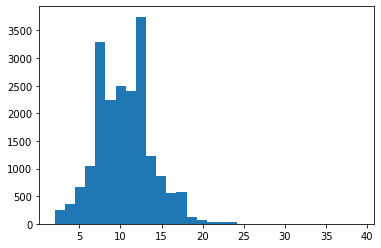

In [23]:
import matplotlib.pyplot as plt

plt.hist([len(doc.split()) for doc in norm_train_h], bins=30);


## Padding text sequences

In [24]:
MAX_SEQUENCE_LENGTH = 25

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((20033, 25), (8586, 25))

## Building FastText based Embedding Matrix

Here I will build an embedding matrix based on pre-trained FastText Embeddings available __[here](https://fasttext.cc/docs/en/english-vectors.html)__.

I will be using the __crawl-300d-2M-subword.vec.zip__ embedding file which has 1 million word vectors trained with subword infomation on 2 million word vectors trained with subword information on Common Crawl (600B tokens).

![](https://i.imgur.com/5de9N5R.png)

In [25]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

## Download Pre-trained FastText Embeddings

In [26]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

--2023-03-28 15:27:08--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.141.13, 13.249.141.9, 13.249.141.40, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.141.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip’

crawl-300d-2M-subwo 100%[===================>]   5.43G  26.5MB/s    in 2m 1s   

2023-03-28 15:29:10 (45.8 MB/s) - ‘crawl-300d-2M-subword.zip’ saved [5828358084/5828358084]



In [27]:
!unzip crawl-300d-2M-subword.zip

Archive:  crawl-300d-2M-subword.zip
  inflating: crawl-300d-2M-subword.vec  
  inflating: crawl-300d-2M-subword.bin  


## Generate Pre-trained Embedding Matrix

In [28]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './crawl-300d-2M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [29]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(22488, 300)

## Build CNN Model Architecture

In [30]:
# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           6746400   
                                                                 
 conv1d (Conv1D)             (None, 25, 256)           307456    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 128)           131200    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 64)             3

## Train and Validate Model

In [31]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, train_if, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
157/157 [==============================] - 30s 103ms/step - loss: 0.4118 - accuracy: 0.8002
Epoch 2/100
157/157 [==============================] - 6s 36ms/step - loss: 0.1500 - accuracy: 0.9456
Epoch 3/100
157/157 [==============================] - 3s 16ms/step - loss: 0.0386 - accuracy: 0.9865
Epoch 4/100
157/157 [==============================] - 4s 24ms/step - loss: 0.0197 - accuracy: 0.9929
Epoch 5/100
157/157 [==============================] - 3s 22ms/step - loss: 0.0091 - accuracy: 0.9969
Epoch 6/100
157/157 [==============================] - 2s 14ms/step - loss: 0.0073 - accuracy: 0.9977
Epoch 7/100
157/157 [==============================] - 2s 14ms/step - loss: 0.0088 - accuracy: 0.9972
Epoch 8/100
157/157 [==============================] - 2s 12ms/step - loss: 0.0038 - accuracy: 0.9986
Epoch 9/100
157/157 [==============================] - 2s 11ms/step - loss: 0.0032 - accuracy: 0.9992
Epoch 10/100
157/157 [==============================] - 2s 15ms/step - loss: 0.0

## Model Performance Evaluation on the Test Dataset

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict(X_test, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(test_if, predictions)*100))
print(classification_report(test_if, predictions))
pd.DataFrame(confusion_matrix(test_if, predictions))

Accuracy: 85.35%
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4455
           1       0.86      0.84      0.85      4131

    accuracy                           0.85      8586
   macro avg       0.85      0.85      0.85      8586
weighted avg       0.85      0.85      0.85      8586



,0,1
0,3872,583
1,675,3456


It is better than before but still not great.

# Model 2: SMALL BERT from the Tensorflow Hub

This section has been inspired by the tutorial at the following link: https://www.tensorflow.org/text/tutorials/classify_text_with_bert 

In [35]:
# I'll use the bert uncased L-2_H-128_A-2/1 model. An overview of other possible models is visible at the above link.

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Let's try the preprocessing model on the first headline and see the output:

In [36]:
text_preprocessed = bert_preprocess_model(train_h[:1].tolist())

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2137  4671  2000  3749  1019  2706  1997  6986 11795  3012  1998
 23676  2681   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Definition of the model

I will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.



In [37]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [38]:
classifier_model = build_classifier_model()


In [39]:
bert_raw_result = classifier_model(tf.constant(train_h[:1].tolist()))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.22371252]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

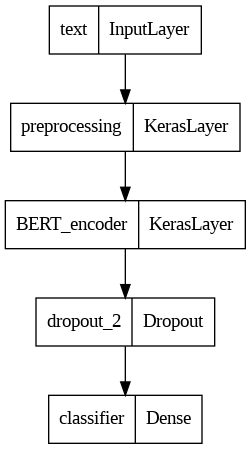

In [40]:
tf.keras.utils.plot_model(classifier_model)

## Model training



### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), I'll use `losses.BinaryCrossentropy` loss function.


In [41]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [42]:
epochs = 5
steps_per_epoch = len(train_h) 
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [43]:
steps_per_epoch

20033

### Loading the BERT model and training

Using the `classifier_model` you created earlier, I can compile the model with the loss, metric and optimizer.

In [44]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [45]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=tf.constant(train_h.tolist()),y=tf.constant(train_if.tolist()),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Epoch 1/5
627/627 [==============================] - 73s 108ms/step - loss: 0.7421 - binary_accuracy: 0.5390
Epoch 2/5
627/627 [==============================] - 65s 104ms/step - loss: 0.5774 - binary_accuracy: 0.6686
Epoch 3/5
627/627 [==============================] - 66s 106ms/step - loss: 0.4580 - binary_accuracy: 0.7754
Epoch 4/5
627/627 [==============================] - 66s 105ms/step - loss: 0.4028 - binary_accuracy: 0.8126
Epoch 5/5
627/627 [==============================] - 65s 104ms/step - loss: 0.3570 - binary_accuracy: 0.8375


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [46]:
loss, accuracy = classifier_model.evaluate(x=tf.constant(test_h[:].tolist()),y=tf.constant(test_if[:].tolist()))

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


269/269 [==============================] - 22s 79ms/step - loss: 0.3415 - binary_accuracy: 0.8393
Loss: 0.3415433466434479
Accuracy: 0.83927321434021


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = [1 if pr > 0.5 else 0 
                   for pr in classifier_model.predict(x=tf.constant(test_h[:].tolist()))]

print(classification_report(test_if[:].tolist(), predictions))

269/269 [==============================] - 28s 99ms/step
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      4455
           1       0.90      0.75      0.82      4131

    accuracy                           0.84      8586
   macro avg       0.85      0.84      0.84      8586
weighted avg       0.85      0.84      0.84      8586



# Model 3: BERT from Huggingface


This section has been inspired by the tutorial at the following link: https://huggingface.co/course/chapter3/2?fw=tf

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification



Huggingface provides many different models. I will try with the most downloaded: "bert-base-uncased"

In [ ]:

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)



All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch = dict(tokenizer(train_h[:].tolist(), padding=True, truncation=True, return_tensors="tf"))
labels = tf.convert_to_tensor(train_if[:].tolist())

In [ ]:
epochs = 5
steps_per_epoch = len(train_h) 
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy() #from_logits=True
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
model.compile(optimizer=optimizer,
                         loss="binary_crossentropy",
              metrics = metrics)

In [ ]:
batch

{'input_ids': <tf.Tensor: shape=(20033, 66), dtype=int32, numpy=
 array([[  101,  2137,  4671, ...,     0,     0,     0],
        [  101,  3422,  1024, ...,     0,     0,     0],
        [  101,  2158,  2040, ...,     0,     0,     0],
        ...,
        [  101,  2120,  4633, ...,     0,     0,     0],
        [  101,  4828,  5651, ...,     0,     0,     0],
        [  101,  7077, 11484, ...,     0,     0,     0]], dtype=int32)>,
 'token_type_ids': <tf.Tensor: shape=(20033, 66), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(20033, 66), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, .

In [ ]:
labels

<tf.Tensor: shape=(20033,), dtype=int32, numpy=array([0, 0, 1, ..., 1, 1, 1], dtype=int32)>

In [ ]:
model.fit(batch, labels, epochs=5)

Epoch 1/5
627/627 [==============================] - 326s 449ms/step - loss: 1.0386 - binary_accuracy: 0.6293
Epoch 2/5
627/627 [==============================] - 279s 445ms/step - loss: 0.5096 - binary_accuracy: 0.8603
Epoch 3/5
627/627 [==============================] - 279s 445ms/step - loss: 0.4369 - binary_accuracy: 0.9081
Epoch 4/5
627/627 [==============================] - 275s 439ms/step - loss: 0.4135 - binary_accuracy: 0.9309
Epoch 5/5
627/627 [==============================] - 274s 437ms/step - loss: 0.4113 - binary_accuracy: 0.9509


In [ ]:
batch_test = dict(tokenizer(test_h[:].tolist(), padding=True, truncation=True, return_tensors="tf"))
labels_test = tf.convert_to_tensor(test_if[:].tolist())

In [ ]:
loss, accuracy = model.evaluate(x=batch_test,y=labels_test)

269/269 [==============================] - 123s 446ms/step - loss: 0.8645 - binary_accuracy: 0.9194


In [ ]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


Loss: 0.8645208477973938
Accuracy: 0.9194036722183228


In [ ]:
pred = model.predict(x=batch_test)

269/269 [==============================] - 129s 451ms/step


In [ ]:
predictions = [1 if pr > 0.5 else 0 
                   for pr in pred["logits"][:, 0]]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4455
           1       0.92      0.91      0.92      4131

    accuracy                           0.92      8586
   macro avg       0.92      0.92      0.92      8586
weighted avg       0.92      0.92      0.92      8586

